## Building an initial model

We begin by verifying that our local instance has access to a GPU.

In [2]:
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


Next, let's download the data that we need.

In [2]:
!aws s3 cp s3://quilt-example/quilt/open_fruit/training_data/X_meta.csv X_meta.csv --quiet
!aws s3 sync s3://quilt-example/quilt/open_fruit/images_cropped/ images_cropped/ --quiet

In [4]:
%ls images_cropped/

Apple/   Grape/       Lemon/   Peach/  Pineapple/   Tomato/
Banana/  Grapefruit/  Orange/  Pear/   Strawberry/  Watermelon/


There is a 25x difference between the occurence rates for the most common and least common classes in the dataset. Oversampling can help, but the number of occurances for the rarest classes is so low that it's better to simply discard them entirely.

In [68]:
# limit the problem space by eliminating the rarest classes
# the model will not be able to perform very well on these classes
# note: Pineapple is not uber rare, but including it would mean
# having 13 classes :-)
!rm -rf 'images_cropped/Mango'
!rm -rf 'images_cropped/Common_fig'
!rm -rf 'images_cropped/Cantaloupe'
!rm -rf 'images_cropped/Pomegranate'

Next, we need to oversample the data. There are two ways to do this. The first way, and the methodology I initially used, is to use the `imblearn.over_sampling.RandomOverSampler` tool in conjunction with `keras.Sequential.fit_dataframe`.

This isn't fundamentally a wrong approach, but there is a simpler way to do this that is recommended when using `keras`: passing class weights to the `class_weight` parameter on the `fit` method. Here we construct that:

In [102]:
import os

labels_count = dict()
for img_class in [ic for ic in os.listdir('images_cropped/') if ic[0] != '.']:
    labels_count[img_class] = len(os.listdir('images_cropped/' + img_class))
total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in enumerate(labels_count.values())}

With `class_weight=class_weights` and with the elimination of the rarest classes, we should have the right starting point for a relatively balanced model.

Next, the model definition. Here's a sketch of the file that will actually run the model:

In [104]:
# %load resnet48/train.py
# from comet_ml import Experiment  # must be imported before keras
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf


# check GPU availability
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


img_dir = 'images_cropped/'
metadata_filepath = 'X_meta.csv'
batch_size = 128


# set up experiment logging
# set COMET_API_KEY in your environment variables
# or pass it as the first value in the Experiment object
# experiment = Experiment(
#     "...",
#     workspace="ceceshao1", project_name="aleksey-open-fruits"
# )


# get X and y values for flow_from_directory
X_meta = pd.read_csv(metadata_filepath)
X = X_meta[['CroppedImageURL']].values
y = X_meta['LabelName'].values


# define data generators
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    rescale=1/255,
)
train_generator = train_datagen.flow_from_directory(
    img_dir,
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
)
validation_generator = train_datagen.flow_from_directory(
    img_dir,
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


# define the model
prior = keras.applications.VGG16(
    include_top=False, 
    weights='imagenet',
    input_shape=(48, 48, 3)
)
model = Sequential()
model.add(prior)
model.add(Flatten())
model.add(Dense(256, activation='relu', name='Dense_Intermediate'))
model.add(Dropout(0.1, name='Dropout_Regularization'))
model.add(Dense(12, activation='sigmoid', name='Output'))


# freeze the vgg16 model
for cnn_block_layer in model.layers[0].layers:
    cnn_block_layer.trainable = False
model.layers[0].trainable = False


# compile the model
model.compile(
    optimizer=RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# fit the model
model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator.filenames) // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(train_generator.filenames) // batch_size,
    callbacks=[
        EarlyStopping(patience=2, restore_best_weights=True)
    ],
    class_weight=class_weights
)


# save model artifact
model.save('/opt/ml/model/model-48.h5')


# experiment.end()

Found 26376 images belonging to 12 classes.
Found 6588 images belonging to 12 classes.
Epoch 1/20
 12/206 [>.............................] - ETA: 2:55 - loss: 62.1871 - acc: 0.2083

KeyboardInterrupt: 

This is just to test that this will run successfully, hence the `KeyboardInterrupt`.

OK, let's talk optimization. We already dealt with the imbalanced learning problem. Next, let's try to find a performant learning rate. We'll use `keras_lr_finder.LRFinder` to do that. But `LRFinder` is `fit`-only, so it requries a bit of jury rigging to get it working (with a representative balanced class sample).

In [163]:
from imblearn.under_sampling import RandomUnderSampler
from keras_lr_finder import LRFinder

lr_find_generator = train_datagen.flow_from_directory(
    img_dir,
    target_size=(48, 48),
    batch_size=8192*2,
    class_mode='categorical',
    subset='training'
)

X_batch, y_batch = next(lr_find_generator)
X_idxs_resampled, _ = RandomUnderSampler().fit_resample(
    np.asarray(range(len(X_batch)))[:, np.newaxis], 
    y_batch.argmax(axis=1)
)

X_batch, y_batch = X_batch[X_idxs_resampled[:, 0]], y_batch[X_idxs_resampled[:, 0]]

lr_finder = LRFinder(model)
lr_finder.find(X_batch, y_batch, start_lr=0.0001, end_lr=1, batch_size=batch_size, epochs=5)

# X_batch takes up a lot of memory
del X_batch
del y_batch

Found 26376 images belonging to 12 classes.
Epoch 1/5
3468/3468 [==============================] - 2s 646us/step - loss: 2.8179 - acc: 0.0908
Epoch 2/5
3468/3468 [==============================] - 2s 555us/step - loss: 2.2403 - acc: 0.2246
Epoch 3/5
3468/3468 [==============================] - 2s 552us/step - loss: 2.2971 - acc: 0.2056
Epoch 4/5
3468/3468 [==============================] - 2s 551us/step - loss: 2.6090 - acc: 0.0874
Epoch 5/5
3468/3468 [==============================] - 2s 550us/step - loss: 4.2652 - acc: 0.0842


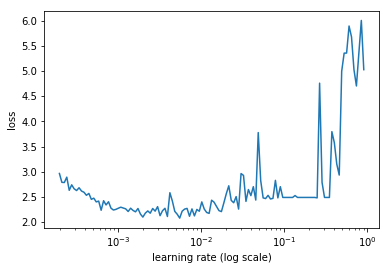

In [164]:
%matplotlib inline
lr_finder.plot_loss()

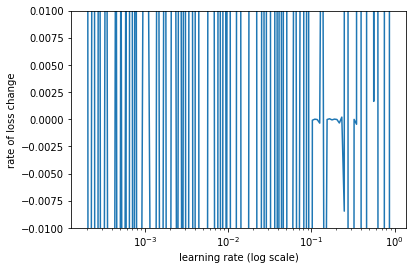

In [165]:
lr_finder.plot_loss_change()

The function is unfortunately not very smooth. There is high variability due to a combination of the small sample size and the resampling overhead constraining how much data `LRFinder` is seeing. We can see that `10^-3` (0.001, the default learning rate) is a good choice.

## Launching the first batch of jobs

### input_size=48, batch_size=512

In [6]:
%%sh
fahr fit resnet48_512/train.py \
    --build-driver='local-gpu' \
    --train-driver='sagemaker' \
    --config.output_path='s3://alpha-quilt-storage/aleksey/progressive-resizing/' \
    --config.role_name='aleksey_sagemaker_role' \
    --config.train_instance_type='ml.p3.2xlarge'

fahr.fahr - INFO - Using "/home/ec2-user/SageMaker/progressive-resizing/resnet48_512/requirements.txt" as envfile.
fahr.fahr - INFO - A Dockerfile already exists at "/home/ec2-user/SageMaker/progressive-resizing/resnet48_512/Dockerfile" and "overwrite" is set to False. The existing Dockerfile will be reused.
fahr.fahr - INFO - An image entrypoint already exists at "/home/ec2-user/SageMaker/progressive-resizing/resnet48_512/run.sh" and "overwrite" is set to False. The existing file will be reused.
fahr.fahr - INFO - Building "resnet48_512/train" container image from "/home/ec2-user/SageMaker/progressive-resizing/resnet48_512".
fahr.fahr - INFO - "resnet48_512/train" repository found in ECR registry 730278974607.
fahr.fahr - INFO - Retrieving auth token for ECR registry 730278974607.
fahr.fahr - INFO - Pushing image to ECR registry 730278974607.
fahr.fahr - INFO - aleksey_sagemaker_role is both the desired IAM role and the current execution context. Creating a new session using the curre

INFO:fahr.fahr:aleksey_sagemaker_role is both the desired IAM role and the current execution context. Creating a new session using the current session authorization credentials.
INFO:fahr.fahr:Fitting resnet48_512/train classifier with job name fahr-resnet48-512-train-2. Using 1x ml.p3.2xlarge compute instances.
INFO:sagemaker:Creating training-job with name: fahr-resnet48-512-train-2
INFO:fahr.fahr:The training job is now running. To track training progress visit https://console.aws.amazon.com/sagemaker/home?#/jobs/fahr-resnet48-512-train-2. To see training logs visit https://console.aws.amazon.com/cloudwatch/home?#logStream:group=/aws/sagemaker/TrainingJobs;streamFilter=typeLogStreamPrefix. To download finished model artifacts run fahr fetch ./ "resnet48_512/train" "s3://alpha-quilt-storage/aleksey/progressive-resizing/" (or similar) after training is complete.


In [1]:
%%sh
fahr fetch ./ "resnet48_512/train" "s3://alpha-quilt-storage/aleksey/progressive-resizing/"

fahr.fahr - INFO - Downloaded model artifact(s) to "/home/ec2-user/SageMaker/progressive-resizing/".


### input_size=48, batch_size=256

In [8]:
%%sh
fahr fit resnet48_256/train.py \
    --build-driver='local-gpu' \
    --train-driver='sagemaker' \
    --config.output_path='s3://alpha-quilt-storage/aleksey/progressive-resizing/' \
    --config.role_name='aleksey_sagemaker_role' \
    --config.train_instance_type='ml.p3.2xlarge'

fahr.fahr - INFO - Using "/home/ec2-user/SageMaker/progressive-resizing/resnet48_256/requirements.txt" as envfile.
fahr.fahr - INFO - A Dockerfile already exists at "/home/ec2-user/SageMaker/progressive-resizing/resnet48_256/Dockerfile" and "overwrite" is set to False. The existing Dockerfile will be reused.
fahr.fahr - INFO - An image entrypoint already exists at "/home/ec2-user/SageMaker/progressive-resizing/resnet48_256/run.sh" and "overwrite" is set to False. The existing file will be reused.
fahr.fahr - INFO - Building "resnet48-256-train" container image from "/home/ec2-user/SageMaker/progressive-resizing/resnet48_256".
fahr.fahr - INFO - "resnet48-256-train" repository not found in ECR registry 730278974607. Creating it now.
fahr.fahr - INFO - Retrieving auth token for ECR registry 730278974607.
fahr.fahr - INFO - Pushing image to ECR registry 730278974607.
fahr.fahr - INFO - aleksey_sagemaker_role is both the desired IAM role and the current execution context. Creating a new se

INFO:fahr.fahr:aleksey_sagemaker_role is both the desired IAM role and the current execution context. Creating a new session using the current session authorization credentials.
INFO:fahr.fahr:Fitting resnet48-256-train classifier with job name resnet48-256-train-1. Using 1x ml.p3.2xlarge compute instances.
INFO:sagemaker:Creating training-job with name: resnet48-256-train-1
INFO:fahr.fahr:The training job is now running. To track training progress visit https://console.aws.amazon.com/sagemaker/home?#/jobs/resnet48-256-train-1. To see training logs visit https://console.aws.amazon.com/cloudwatch/home?#logStream:group=/aws/sagemaker/TrainingJobs;streamFilter=typeLogStreamPrefix. To download finished model artifacts run fahr fetch ./ "resnet48-256-train" "s3://alpha-quilt-storage/aleksey/progressive-resizing/" (or similar) after training is complete.


### input_size=48, batch_size=128

In [9]:
%%sh
fahr fit resnet48_128/train.py \
    --build-driver='local-gpu' \
    --train-driver='sagemaker' \
    --config.output_path='s3://alpha-quilt-storage/aleksey/progressive-resizing/' \
    --config.role_name='aleksey_sagemaker_role' \
    --config.train_instance_type='ml.p2.xlarge'

fahr.fahr - INFO - Using "/home/ec2-user/SageMaker/progressive-resizing/resnet48_128/requirements.txt" as envfile.
fahr.fahr - INFO - A Dockerfile already exists at "/home/ec2-user/SageMaker/progressive-resizing/resnet48_128/Dockerfile" and "overwrite" is set to False. The existing Dockerfile will be reused.
fahr.fahr - INFO - An image entrypoint already exists at "/home/ec2-user/SageMaker/progressive-resizing/resnet48_128/run.sh" and "overwrite" is set to False. The existing file will be reused.
fahr.fahr - INFO - Building "resnet48-128-train" container image from "/home/ec2-user/SageMaker/progressive-resizing/resnet48_128".
fahr.fahr - INFO - "resnet48-128-train" repository not found in ECR registry 730278974607. Creating it now.
fahr.fahr - INFO - Retrieving auth token for ECR registry 730278974607.
fahr.fahr - INFO - Pushing image to ECR registry 730278974607.
fahr.fahr - INFO - aleksey_sagemaker_role is both the desired IAM role and the current execution context. Creating a new se

INFO:fahr.fahr:aleksey_sagemaker_role is both the desired IAM role and the current execution context. Creating a new session using the current session authorization credentials.
INFO:fahr.fahr:Fitting resnet48-128-train classifier with job name resnet48-128-train-1. Using 1x ml.p2.xlarge compute instances.
INFO:sagemaker:Creating training-job with name: resnet48-128-train-1
INFO:fahr.fahr:The training job is now running. To track training progress visit https://console.aws.amazon.com/sagemaker/home?#/jobs/resnet48-128-train-1. To see training logs visit https://console.aws.amazon.com/cloudwatch/home?#logStream:group=/aws/sagemaker/TrainingJobs;streamFilter=typeLogStreamPrefix. To download finished model artifacts run fahr fetch ./ "resnet48-128-train" "s3://alpha-quilt-storage/aleksey/progressive-resizing/" (or similar) after training is complete.


## Evaluating the first batch of jobs

**Note**: the below should work in theory, except for a logic error I made in the naming of jobs in the version of `fahr` that ran these jobs (since fixed). So I downloaded the resultant artifacts by hand.

**Note**: typically I would evaluate model performance using the CometML tooling. Unfortunately that did not work for this run because I didn't enable model history in the callback (history is not written for you automatically if you use `fit_generator`; TIL). So I write out observations on the model history by hand by reading it from the training logs.

In [17]:
# %%sh
# fahr fetch ./ "resnet48-256/train" "s3://alpha-quilt-storage/aleksey/progressive-resizing/"
# fahr fetch ./ "resnet48-128/train" "s3://alpha-quilt-storage/aleksey/progressive-resizing/"

In [32]:
!aws s3 cp \
    s3://alpha-quilt-storage/aleksey/progressive-resizing/resnet48-128-train-1/output/model.tar.gz \
    ./model.tar.gz && \
 tar -xzf model.tar.gz -C resnet48_128 && \
 rm model.tar.gz

download: s3://alpha-quilt-storage/aleksey/progressive-resizing/resnet48-128-train-1/output/model.tar.gz to ./model.tar.gz


In [33]:
!aws s3 cp \
    s3://alpha-quilt-storage/aleksey/progressive-resizing/resnet48-256-train-1/output/model.tar.gz \
    ./model.tar.gz && \
 tar -xzf model.tar.gz -C resnet48_256 && \
 rm model.tar.gz

download: s3://alpha-quilt-storage/aleksey/progressive-resizing/resnet48-256-train-1/output/model.tar.gz to ./model.tar.gz


The 256 batch size model stopped at 20 epochs with slightly improved validation accuracy.

```
103/103 [==============================] - 773s 8s/step - loss: 1.2621 - acc: 0.5751 - val_loss: 1.3608 - val_acc: 0.5426
```

The 128 batch size model stopped at 20 epochs also with even more improved validation accuracy.

```
206/206 [==============================] - 852s 4s/step - loss: 1.2347 - acc: 0.5829 - val_loss: 1.3455 - val_acc: 0.5524
```

Note that this 1% improvement came from seeing 2x as many batches, and cost 1/4 the cost of 256 model to train. Whilst arguably one might find even better performance by dipping even lower in epoch size, let's stop here.

## Progressive resizing

We're not going to spend any more time iterating on this basic model structure. Let's jump instead to progressive resizing (we may also attempt ensembling later).

In [69]:
# just checking VGG layer output shapes

import keras
_prior = keras.applications.VGG16(
    include_top=False, 
    weights='imagenet',
    input_shape=(48, 48, 3)
)

print(_prior.layers[1].input_shape)
print(_prior.layers[1].output_shape)
print(_prior.layers[2].input_shape)
print(_prior.layers[2].output_shape)
print(_prior.layers[3].input_shape)
print(_prior.layers[3].output_shape)

(None, 48, 48, 3)
(None, 48, 48, 64)
(None, 48, 48, 64)
(None, 48, 48, 64)
(None, 48, 48, 64)
(None, 24, 24, 64)


In [16]:
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf


# check GPU availability
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


img_dir = 'images_cropped/'
metadata_filepath = 'X_meta.csv'
batch_size = 128


# set up experiment logging
# set COMET_API_KEY in your environment variables
# or pass it as the first value in the Experiment object
# experiment = Experiment(
#     "...",
#     workspace="ceceshao1", project_name="aleksey-open-fruits"
# )


# get X and y values for flow_from_directory
X_meta = pd.read_csv(metadata_filepath)
X = X_meta[['CroppedImageURL']].values
y = X_meta['LabelName'].values


# define data generators
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    rescale=1/255,
)
train_generator = train_datagen.flow_from_directory(
    img_dir,
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
)
validation_generator = train_datagen.flow_from_directory(
    img_dir,
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


prior = load_model('model-48.h5')
# prior = load_model('./resnet48_128/model-48.h5')

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(96, 96, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(96, 96, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

for layer in prior.layers[0].layers[2:]:
    model.add(layer)

for layer in prior.layers[1:]:
    model.add(layer)
    
for layer in prior.layers[-4:]:
    layer.trainable = False
    

# compile the model
model.compile(
    optimizer=RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# generate class weights
import os
labels_count = dict()
for img_class in [ic for ic in os.listdir('images_cropped/') if ic[0] != '.']:
    labels_count[img_class] = len(os.listdir('images_cropped/' + img_class))
total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in enumerate(labels_count.values())}


# fit the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator.filenames) // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(train_generator.filenames) // batch_size,
    callbacks=[
        EarlyStopping(patience=2, restore_best_weights=True)
    ],
    class_weight=class_weights
)

# save model artifacts
model.save('/opt/ml/model/model-96.h5')
with open('/opt/ml/model/model-96-history.pickle', 'wb') as fp:
        pickle.dump(history.history, fp)

Found 26376 images belonging to 12 classes.
Found 6588 images belonging to 12 classes.
Epoch 1/20
  3/206 [..............................] - ETA: 4:44 - loss: 83.8500 - acc: 0.0964

KeyboardInterrupt: 

Determine a good learning rate again.

In [4]:
from imblearn.under_sampling import RandomUnderSampler
from keras_lr_finder import LRFinder

lr_find_generator = train_datagen.flow_from_directory(
    img_dir,
    target_size=(96, 96),
    batch_size=8192*2,
    class_mode='categorical',
    subset='training'
)

X_batch, y_batch = next(lr_find_generator)
X_idxs_resampled, _ = RandomUnderSampler().fit_resample(
    np.asarray(range(len(X_batch)))[:, np.newaxis], 
    y_batch.argmax(axis=1)
)

X_batch, y_batch = X_batch[X_idxs_resampled[:, 0]], y_batch[X_idxs_resampled[:, 0]]

lr_finder = LRFinder(model)
lr_finder.find(X_batch, y_batch, start_lr=0.0001, end_lr=1, batch_size=batch_size, epochs=5)

# X_batch takes up a lot of memory
del X_batch
del y_batch

Found 26376 images belonging to 12 classes.
Epoch 1/5
3924/3924 [==============================] - 7s 2ms/step - loss: 3.4248 - acc: 0.0841
Epoch 2/5
3924/3924 [==============================] - 6s 1ms/step - loss: 3.1037 - acc: 0.0851
Epoch 3/5
3924/3924 [==============================] - 6s 1ms/step - loss: 2.6715 - acc: 0.1075
Epoch 4/5
3924/3924 [==============================] - 6s 1ms/step - loss: 2.5909 - acc: 0.1465
Epoch 5/5
3924/3924 [==============================] - 6s 1ms/step - loss: 3.2045 - acc: 0.1218


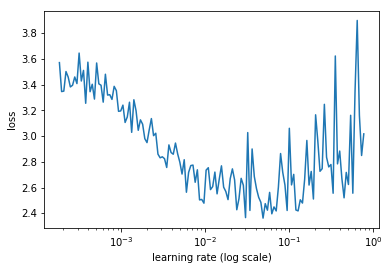

In [5]:
%matplotlib inline
lr_finder.plot_loss()

The default LR is still a good choice.

In [24]:
%ls

images_cropped/  resnet48_128/  resnet96_128/     tmp.h5
model-48.h5      resnet48_256/  scratchpad.ipynb  X_meta.csv
README.md        resnet48_512/  setup.sh


In [1]:
from fahr.fahr import get_next_job_name, get_previous_job_name

In [2]:
get_previous_job_name('resnet96-128-train')

In [3]:
get_next_job_name('resnet96-128-train')

'fahr-resnet96-128-train-1'

In [6]:
%%sh
fahr fit resnet96_128/train.py \
    --build-driver='local-gpu' \
    --train-driver='sagemaker' \
    --config.output_path='s3://alpha-quilt-storage/aleksey/progressive-resizing/' \
    --config.role_name='aleksey_sagemaker_role' \
    --config.train_instance_type='ml.p2.xlarge'

fahr.fahr - INFO - Using "/home/ec2-user/SageMaker/progressive-resizing/resnet96_128/requirements.txt" as envfile.
fahr.fahr - INFO - A Dockerfile already exists at "/home/ec2-user/SageMaker/progressive-resizing/resnet96_128/Dockerfile" and "overwrite" is set to False. The existing Dockerfile will be reused.
fahr.fahr - INFO - An image entrypoint already exists at "/home/ec2-user/SageMaker/progressive-resizing/resnet96_128/run.sh" and "overwrite" is set to False. The existing file will be reused.
fahr.fahr - INFO - Building "resnet96-128-train" container image from "/home/ec2-user/SageMaker/progressive-resizing/resnet96_128".
fahr.fahr - INFO - "resnet96-128-train" repository found in ECR registry 730278974607.
fahr.fahr - INFO - Retrieving auth token for ECR registry 730278974607.
fahr.fahr - INFO - Pushing image to ECR registry 730278974607.
fahr.fahr - INFO - aleksey_sagemaker_role is both the desired IAM role and the current execution context. Creating a new session using the curre

INFO:fahr.fahr:aleksey_sagemaker_role is both the desired IAM role and the current execution context. Creating a new session using the current session authorization credentials.
INFO:fahr.fahr:Fitting resnet96-128-train classifier with job name fahr-resnet96-128-train-1. Using 1x ml.p2.xlarge compute instances.
INFO:sagemaker:Creating training-job with name: fahr-resnet96-128-train-1
INFO:fahr.fahr:The training job is now running. To track training progress visit https://console.aws.amazon.com/sagemaker/home?#/jobs/fahr-resnet96-128-train-1. To see training logs visit https://console.aws.amazon.com/cloudwatch/home?#logStream:group=/aws/sagemaker/TrainingJobs;streamFilter=typeLogStreamPrefix. To download finished model artifacts run fahr fetch ./ "resnet96-128-train" "s3://alpha-quilt-storage/aleksey/progressive-resizing/" (or similar) after training is complete.


In [7]:
%%sh
fahr fetch ./ "resnet96-128-train" "s3://alpha-quilt-storage/aleksey/progressive-resizing/"

fahr.fahr - INFO - Downloaded model artifact(s) to "/home/ec2-user/SageMaker/progressive-resizing/".


### Evaluating the job result

In [10]:
import pickle

with open("model-96-history.pickle", "rb") as fp:
    history = pickle.load(fp)

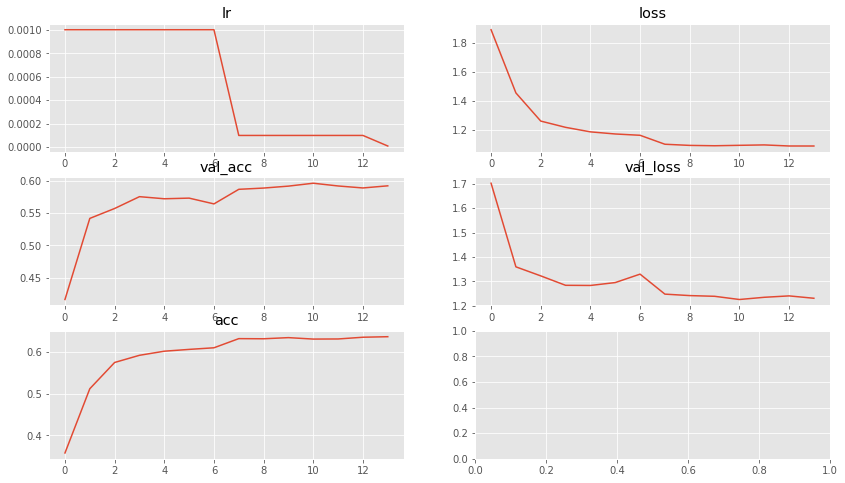

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fig, axarr = plt.subplots(3, 2, figsize=(14, 8))
for i, metric in enumerate(history):
    res = history[metric]
    j, k = i // 2, i % 2
    axarr[j][k].plot(range(len(res)), res)
    axarr[j][k].set_title(metric)

Validation accuracy is now ~59.5%, up from 55%&mdash;a 4.5% improvement!

## One more round of resizing

In [1]:
# from comet_ml import Experiment  # must be imported before keras
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import pickle


# check GPU availability
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


img_dir = 'images_cropped/'
metadata_filepath = 'X_meta.csv'
batch_size = 128


# set up experiment logging
# set COMET_API_KEY in your environment variables
# or pass it as the first value in the Experiment object
# experiment = Experiment(
#     "CgFCfEAIYJVIxez3BZzCqFeeX",
#     workspace="ceceshao1", project_name="aleksey-open-fruits"
# )


# get X and y values for flow_from_directory
X_meta = pd.read_csv(metadata_filepath)
X = X_meta[['CroppedImageURL']].values
y = X_meta['LabelName'].values


# define data generators
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    rescale=1/255,
)
train_generator = train_datagen.flow_from_directory(
    img_dir,
    target_size=(192, 192),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
)
validation_generator = train_datagen.flow_from_directory(
    img_dir,
    target_size=(192, 192),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


# define the model

# init a new model with 192x192 CNN layers
# padding='same' will downsample to 96x96
# # which is the expected input size for pretrain
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(192, 192, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# load the pretrained model
prior = load_model('model-96.h5')

# add all but the first two layers of VGG16 to the new model
# strip the input layer out, this is now 96x96
# also strip out the first convolutional layer, this took the 96x96 input and convolved it but
# this is now the job of the three new layers.
for layer in prior.layers[1:]:
    layer.name += '_prior'  # set layer names to avoid name collisions
    model.add(layer)

# the pretrained CNN layers are already marked non-trainable
# mark off the top layers as well
for layer in prior.layers[-4:]:
    layer.trainable = False
    

# compile the model
model.compile(
    optimizer=RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# generate class weights
import os
labels_count = dict()
for img_class in [ic for ic in os.listdir('images_cropped/') if ic[0] != '.']:
    labels_count[img_class] = len(os.listdir('images_cropped/' + img_class))
total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in enumerate(labels_count.values())}


# fit the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator.filenames) // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(train_generator.filenames) // batch_size,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ReduceLROnPlateau(patience=2)
    ]
)

Using TensorFlow backend.


Found 26376 images belonging to 12 classes.
Found 6588 images belonging to 12 classes.
Epoch 1/20
  4/206 [..............................] - ETA: 12:29 - loss: 2.8901 - acc: 0.1680

KeyboardInterrupt: 

In [80]:
from imblearn.under_sampling import RandomUnderSampler
from keras_lr_finder import LRFinder

lr_find_generator = train_datagen.flow_from_directory(
    img_dir,
    target_size=(192, 192),
    batch_size=8192*2,
    class_mode='categorical',
    subset='training'
)

X_batch, y_batch = next(lr_find_generator)
X_idxs_resampled, _ = RandomUnderSampler().fit_resample(
    np.asarray(range(len(X_batch)))[:, np.newaxis], 
    y_batch.argmax(axis=1)
)

X_batch, y_batch = X_batch[X_idxs_resampled[:, 0]], y_batch[X_idxs_resampled[:, 0]]

lr_finder = LRFinder(model)
lr_finder.find(X_batch, y_batch, start_lr=0.0001, end_lr=1, batch_size=batch_size, epochs=5)

# X_batch takes up a lot of memory
del X_batch
del y_batch

Found 26376 images belonging to 12 classes.
Epoch 1/5
3684/3684 [==============================] - 39s 11ms/step - loss: 2.2301 - acc: 0.2448
Epoch 2/5
3684/3684 [==============================] - 34s 9ms/step - loss: 2.2197 - acc: 0.2818
Epoch 3/5
3684/3684 [==============================] - 33s 9ms/step - loss: 2.8779 - acc: 0.1789
Epoch 4/5
 512/3684 [===>..........................] - ETA: 28s - loss: 6.3573 - acc: 0.0840

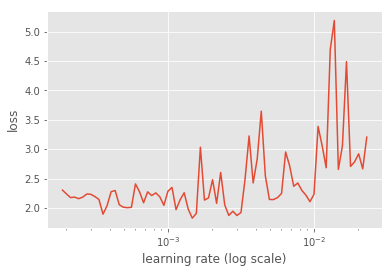

In [81]:
%matplotlib inline
lr_finder.plot_loss()

The default LR is still good.

In [3]:
%%sh
fahr fit resnet192_128/train.py \
    --build-driver='local-gpu' \
    --train-driver='sagemaker' \
    --config.output_path='s3://alpha-quilt-storage/aleksey/progressive-resizing/' \
    --config.role_name='aleksey_sagemaker_role' \
    --config.train_instance_type='ml.p3.2xlarge'

fahr.fahr - INFO - Using "/home/ec2-user/SageMaker/progressive-resizing/resnet192_128/requirements.txt" as envfile.
fahr.fahr - INFO - A Dockerfile already exists at "/home/ec2-user/SageMaker/progressive-resizing/resnet192_128/Dockerfile" and "overwrite" is set to False. The existing Dockerfile will be reused.
fahr.fahr - INFO - An image entrypoint already exists at "/home/ec2-user/SageMaker/progressive-resizing/resnet192_128/run.sh" and "overwrite" is set to False. The existing file will be reused.
fahr.fahr - INFO - Building "resnet192-128-train" container image from "/home/ec2-user/SageMaker/progressive-resizing/resnet192_128".
fahr.fahr - INFO - "resnet192-128-train" repository found in ECR registry 730278974607.
fahr.fahr - INFO - Retrieving auth token for ECR registry 730278974607.
fahr.fahr - INFO - Pushing image to ECR registry 730278974607.
fahr.fahr - INFO - aleksey_sagemaker_role is both the desired IAM role and the current execution context. Creating a new session using the

INFO:fahr.fahr:aleksey_sagemaker_role is both the desired IAM role and the current execution context. Creating a new session using the current session authorization credentials.
INFO:fahr.fahr:Fitting resnet192-128-train classifier with job name fahr-resnet192-128-train-5. Using 1x ml.p3.2xlarge compute instances.
INFO:sagemaker:Creating training-job with name: fahr-resnet192-128-train-5
INFO:fahr.fahr:The training job is now running. To track training progress visit https://console.aws.amazon.com/sagemaker/home?#/jobs/fahr-resnet192-128-train-5. To see training logs visit https://console.aws.amazon.com/cloudwatch/home?#logStream:group=/aws/sagemaker/TrainingJobs;streamFilter=typeLogStreamPrefix. To download finished model artifacts run fahr fetch ./ "resnet192-128-train" "s3://alpha-quilt-storage/aleksey/progressive-resizing/" (or similar) after training is complete.


## Checking train size

In [16]:
prior = keras.applications.VGG16(
    include_top=False, 
    weights='imagenet',
    input_shape=(48, 48, 3)
)
model = Sequential()
model.add(prior)
model.add(Flatten())
model.add(Dense(256, activation='relu', name='Dense_Intermediate'))
model.add(Dropout(0.1, name='Dropout_Regularization'))
model.add(Dense(12, activation='sigmoid', name='Output'))


# compile the model
model.compile(
    optimizer=RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
Dense_Intermediate (Dense)   (None, 256)               131328    
_________________________________________________________________
Dropout_Regularization (Drop (None, 256)               0         
_________________________________________________________________
Output (Dense)               (None, 12)                3084      
Total params: 14,849,100
Trainable params: 14,849,100
Non-trainable params: 0
_________________________________________________________________
